In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from toy_model import *
import sys 
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

In [7]:
data_model = reaction_diffusion_equation()
dataset = data_model.generate_training_data(500, 10, dlt_t = 0.001)

In [8]:
input_dim = 2
hidden_dims = [64, 64, 64]
m_dim = 16
lambda1, lambda2 = 0.1, 1

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ParaModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, m_dim):
        super(ParaModel, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        self.relu_layers = nn.Sequential(*layers)
        
        self.output_layer = nn.Linear(hidden_dims[-1], m_dim)
        self.W = nn.Parameter(torch.randn(m_dim, m_dim), requires_grad=True)
        
    def forward(self, x):
        x = self.relu_layers(x)
        x = self.output_layer(x)
        return x

    # def orthogonal(self, x):
    #     x = self.forward(x)
    #     x = torch.matmul(x, self.W)
    #     return x

In [10]:
def custom_loss_function(h_outputs, y, lace, mu, lambda1, lambda2, m_dim):
    # Compute g as the product of mu and lace
    g = mu * lace
    # Compute u_x as the difference between y and g, and remove extra dimensions
    u_x = (y - g).squeeze()

    # Initialize the squared norm of g's projection onto the subspace spanned by h_outputs
    proj_g_norm_squared = 0

    # For each vector in the orthogonal basis h_outputs
    for i in range(m_dim):
        h_i = h_outputs[:, i]
        # Calculate the projection coefficient of g onto h_i and accumulate the squares of these projections
        proj_coefficient = (torch.dot(g.squeeze(), h_i) / torch.dot(h_i, h_i))
        proj_g_norm_squared += proj_coefficient ** 2

    # Initialize the squared norm of u_x's projection onto the subspace spanned by h_outputs
    proj_u_x_norm_squared = 0
    k_i_values = torch.zeros(m_dim, device=h_outputs.device)

    for i in range(m_dim):
        h_i = h_outputs[:, i]
        # Calculate the projection coefficient of u_x onto h_i
        proj_coefficient_u_x = (torch.dot(u_x, h_i) / torch.dot(h_i, h_i))
        proj_u_x_norm_squared += proj_coefficient_u_x ** 2
        k_i_values[i] = proj_coefficient_u_x

    # Define loss1 as the lambda1-weighted squared norm of g's projection
    loss1 = lambda1 * proj_g_norm_squared
    # Define loss2 based on the squared difference between u_x and its projection onto the subspace
    loss2 = lambda2 * torch.sum((torch.matmul(h_outputs, k_i_values.unsqueeze(1)).squeeze() - u_x) ** 2)

    # Calculate the total loss as the sum of loss1 and loss2
    total_loss = loss1 + loss2

    return total_loss, loss1, loss2


In [ ]:
# ans = y - mu * lace
# custom_loss_function(ans, y, lace, mu, lambda1, lambda2, 1)


In [25]:
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
for x, y, lace in dataloader:
    break

In [ ]:
lace_mean = torch.mean(lace)
y_mean = torch.mean(y)

mu_numerator = torch.sum((lace - lace_mean) * (y - y_mean))
mu_denominator = torch.sum((lace - lace_mean) ** 2)
mu = mu_numerator / mu_denominator

print("Estimated mu:", mu.item())


Estimated mu: -0.2289697676897049


In [6]:
model_h = ParaModel(input_dim, hidden_dims, m_dim)
print(model_h)

NameError: name 'ParaModel' is not defined

In [ ]:
model_h = torch.load('reaction_diffusion_model_h.pth')

In [ ]:
def train_one_epoch(model, optim, data_loader, epoch, mu, lambda1, lambda2):
    model.train()
    train_loss = 0
    train_loss1 = 0
    train_loss2 = 0

    print(f"Training Epoch: {epoch+1}")
    for x, y, lace in data_loader:
        
        h_outputs = model(torch.cat((x, lace), dim = 1))
        Q, R = torch.linalg.qr(h_outputs, mode='reduced')
        
        # R_inv = torch.linalg.inv(R)

        # with torch.no_grad():
            # model.W.data = R_inv

        # h_outputs = model.orthogonal(x)
        optim.zero_grad()
        loss, loss1, loss2 = custom_loss_function(Q, y, lace, mu, lambda1, lambda2, m_dim)
        loss.backward()
        optim.step()
        # print(loss.item())
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Gradient of {name} is {param.grad.norm().item()}")  # 打印梯度的范数


        train_loss += loss.item()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
    

    avg_train_loss = train_loss / len(data_loader)
    avg_train_loss1 = train_loss1 / len(data_loader)
    avg_train_loss2 = train_loss2 / len(data_loader)
    print(f"Average Training Loss for Epoch {epoch+1}: {avg_train_loss:.4e}; Loss1: {avg_train_loss1:.4e}; Loss2: {avg_train_loss2:.4e}")

    return avg_train_loss, avg_train_loss1, avg_train_loss2


In [ ]:
optim = Adam(model_h.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)
scheduler = StepLR(optim, step_size=50, gamma=0.9)

In [ ]:
epochs = 1000
train_losses = []
train_losses1 = []
train_losses2 = []

In [ ]:
for epoch in range(epochs):
    train_loss, train_loss1, train_loss2 = train_one_epoch(model_h, optim, dataloader, epoch, mu, lambda1, lambda2)
    train_losses.append(train_loss)
    train_losses1.append(train_loss1)
    train_losses2.append(train_loss2)
    scheduler.step()

Training Epoch: 1
Average Training Loss for Epoch 1: 6.9450e-04; Loss1: 6.8716e-04; Loss2: 7.3434e-06
Training Epoch: 2
Average Training Loss for Epoch 2: 6.9616e-04; Loss1: 6.8901e-04; Loss2: 7.1449e-06
Training Epoch: 3
Average Training Loss for Epoch 3: 6.9563e-04; Loss1: 6.8828e-04; Loss2: 7.3482e-06
Training Epoch: 4
Average Training Loss for Epoch 4: 6.9411e-04; Loss1: 6.8675e-04; Loss2: 7.3545e-06
Training Epoch: 5
Average Training Loss for Epoch 5: 6.9231e-04; Loss1: 6.8493e-04; Loss2: 7.3782e-06
Training Epoch: 6
Average Training Loss for Epoch 6: 6.9103e-04; Loss1: 6.8371e-04; Loss2: 7.3204e-06
Training Epoch: 7
Average Training Loss for Epoch 7: 6.9013e-04; Loss1: 6.8273e-04; Loss2: 7.4020e-06
Training Epoch: 8
Average Training Loss for Epoch 8: 6.8965e-04; Loss1: 6.8233e-04; Loss2: 7.3266e-06
Training Epoch: 9
Average Training Loss for Epoch 9: 6.8931e-04; Loss1: 6.8194e-04; Loss2: 7.3676e-06
Training Epoch: 10
Average Training Loss for Epoch 10: 6.8914e-04; Loss1: 6.8182e-

In [ ]:
torch.save(model_h, 'reaction_diffusion_model_h.pth')

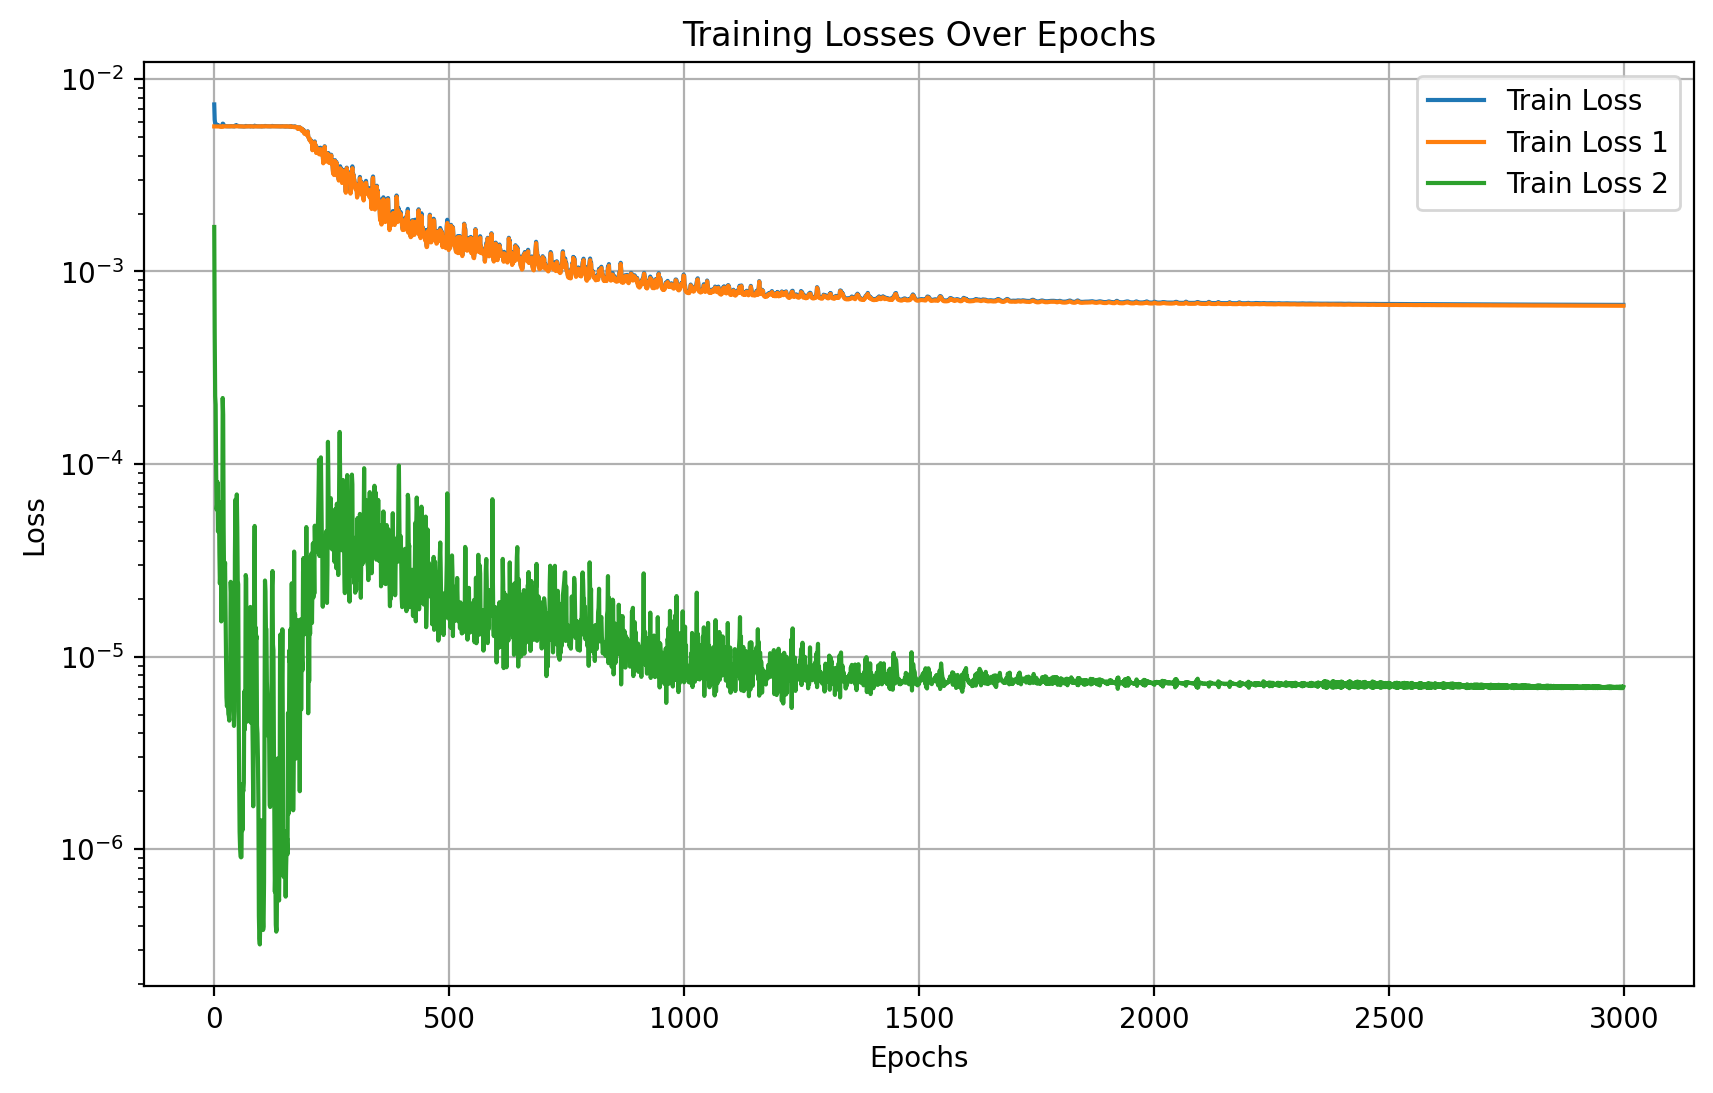

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(train_losses1, label='Train Loss 1')
plt.plot(train_losses2, label='Train Loss 2')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate

In [11]:
def optimize_g(lace, y):
    lace_mean = torch.mean(lace)
    y_mean = torch.mean(y)

    mu_numerator = torch.sum((lace - lace_mean) * (y - y_mean))
    mu_denominator = torch.sum((lace - lace_mean) ** 2)
    mu = mu_numerator / mu_denominator

    return mu

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearRegressionLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias = False)
    
    def forward(self, x):
        return self.linear(x)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardLayer, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


In [14]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset

def train_linear_layer(model, linear_layer, x, lace, y, epochs=100, learning_rate=0.001, batch_size=512):
    for param in model.parameters():
        param.requires_grad = False
    
    optimizer = optim.Adam(linear_layer.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    dataset = TensorDataset(x, y, lace)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    scheduler = StepLR(optimizer, step_size=50, gamma=0.9)

    for epoch in range(epochs):
        model.eval()
        total_loss = 0

        for batch_x, batch_y, batch_lace in data_loader:
            inputs = torch.cat((batch_x, batch_lace), dim = 1)
            outputs = model(inputs)
            predictions = linear_layer(outputs)

            loss = criterion(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        scheduler.step()

In [28]:
# model_h_init = ParaModel(input_dim, hidden_dims, m_dim)
model_h_init = torch.load('./reaction_diffusion_output/reaction_diffusion_model_random.pth')
model_h = torch.load('./reaction_diffusion_output/reaction_diffusion_model_h.pth')

In [16]:
linear_init = FeedforwardLayer(m_dim, m_dim, 1)
linear_h = FeedforwardLayer(m_dim, m_dim, 1)

In [22]:
# dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# for x, y, lace in dataloader:
#     break
# y_g = y

# err_history_init = []
iterations = 5
inputs = torch.cat((x, lace), dim =1)
for iteration in range(iterations):
    mu_init = optimize_g(lace, y_g)
    print(iteration)
    y_h = y - mu_init * lace
    train_linear_layer(model_h_init, linear_init, x, lace, y_h, epochs=300, learning_rate=0.001)
    y_g = y - linear_init(model_h_init(inputs)).detach()
    err = torch.norm(y - y_h- y_g)
    print(err)
    err_history_init.append(err.item())

0
tensor(0.9276)
1
tensor(0.9204)
2
tensor(1.0023)
3
tensor(0.9330)
4
tensor(0.9069)


In [23]:
# dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# for x, y, lace in dataloader:
#     break
# y_g = y

# err_history_h = []
iterations = 5
inputs = torch.cat((x, lace), dim =1)
for iteration in range(iterations):
    mu_h = optimize_g(lace, y_g)
    print(iteration)
    y_h = y - mu_h * lace
    train_linear_layer(model_h, linear_h, x, lace, y_h, epochs=300, learning_rate=0.001)
    y_g = y - linear_h(model_h(inputs)).detach()
    err = torch.norm(y - y_h- y_g)
    print(err)
    err_history_h.append(err.item())

0
tensor(0.0492)
1
tensor(0.0459)
2
tensor(0.0505)
3
tensor(0.0331)
4
tensor(0.0452)


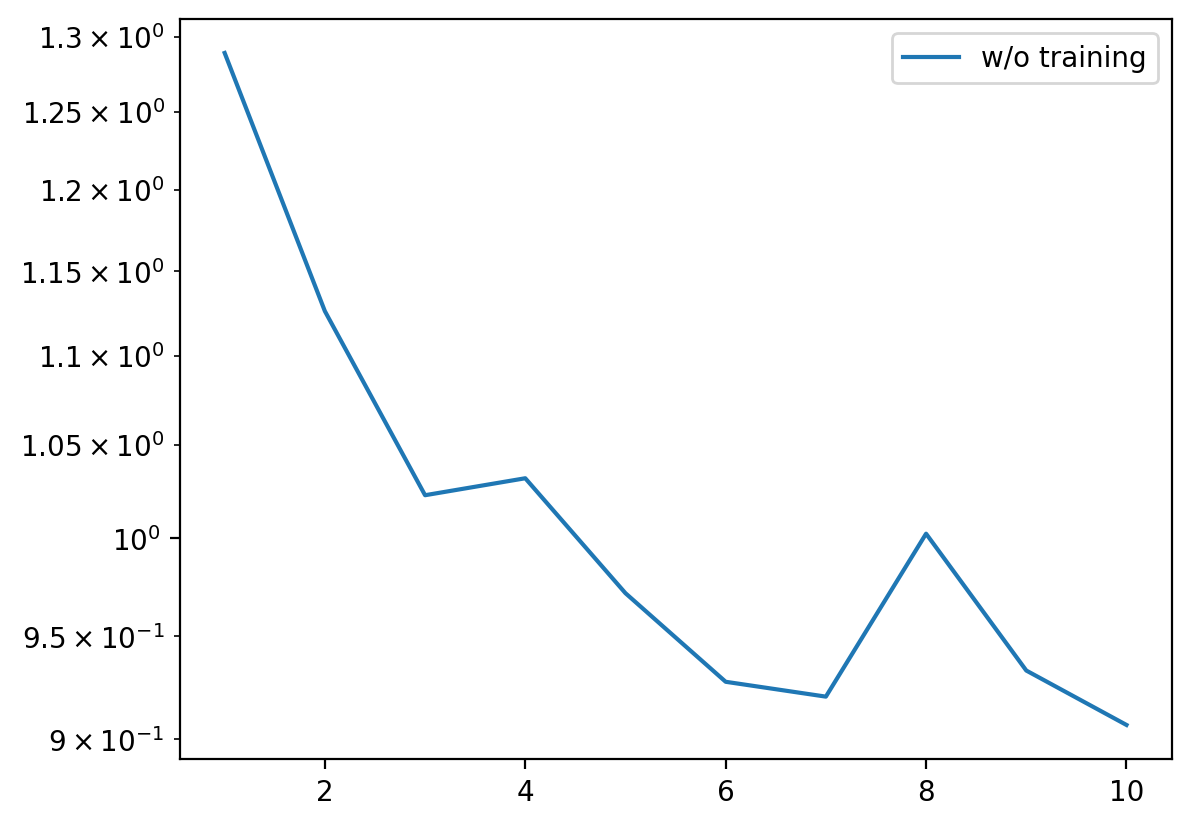

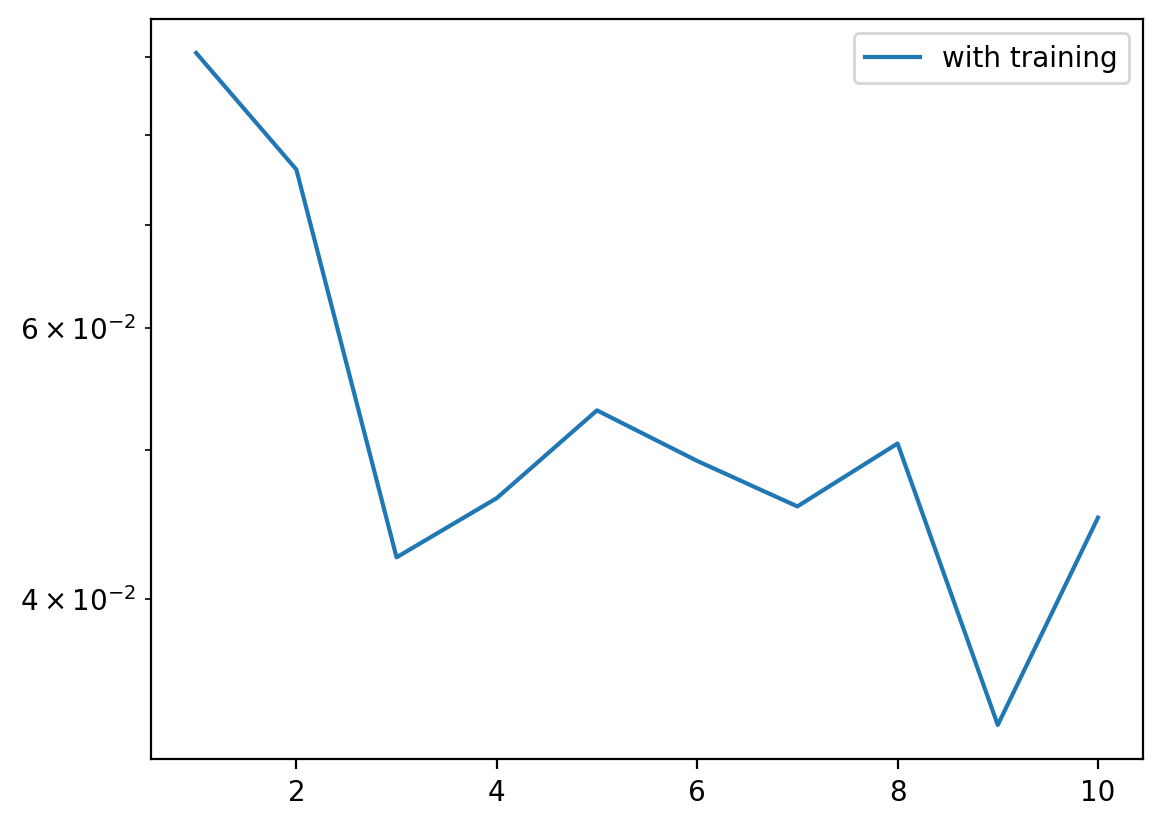

In [26]:
# err_history_diff_init = [err_history_init[i] - err_history_init[-1] for i in range(len(err_history_init))]
# err_history_diff_h = [err_history_h[i] - err_history_h[-1] for i in range(len(err_history_h))]

plt.figure()
plt.plot(range(1, 11), err_history_init, label = 'w/o training')
plt.legend()
plt.yscale('log')


plt.figure()
plt.plot(range(1, 11), err_history_h, label = 'with training')
plt.legend()
plt.yscale('log')



In [25]:
np.save('err_history_init_ffw.npy', err_history_init)
np.save('err_history_h_ffw.npy', err_history_h)